# Air Quality Time Series Forecasting

## Library

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow.keras import regularizers

- Load all the required libraries

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False) 

- Ensure all columns in the dataset are visible

## Understanding Data

In [6]:
data= pd.read_csv('AP004.csv') 

In [7]:
data= data.sort_values(by='From Date')

- Sort the dataset by the 'from date' column to ensure everything is properly ordered

In [8]:
print(data.shape)
data.head()

(48802, 25)


,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),Toluene (ug/m3),Eth-Benzene (ug/m3),MP-Xylene (ug/m3),Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
0,2017-09-05 14:00:00,2017-09-05 15:00:00,25.00,45.00,1.80,12.20,7.90,10.20,5.60,0.35,79.50,0.10,3.50,NaN,0.10,30.30,69.00,3.20,213.00,372.00,747.00,0.10,33.80,0.00,0.50
1,2017-09-05 15:00:00,2017-09-05 16:00:00,23.00,49.50,0.65,14.55,8.28,8.85,4.52,0.41,62.50,0.15,2.83,NaN,0.08,30.00,70.50,4.10,140.00,290.75,747.25,0.05,32.22,0.00,0.48
2,2017-09-05 16:00:00,2017-09-05 17:00:00,18.00,55.75,4.00,26.58,17.40,6.23,5.35,0.38,40.50,0.53,3.05,NaN,0.13,29.85,88.00,2.82,174.75,300.25,747.00,0.00,28.30,0.93,0.53
3,2017-09-05 17:00:00,2017-09-05 18:00:00,19.75,33.50,1.63,21.78,12.92,8.30,5.30,0.48,34.43,0.48,4.88,NaN,0.28,29.25,88.75,1.72,231.50,225.50,747.75,0.00,28.77,0.00,1.85
4,2017-09-05 18:00:00,2017-09-05 19:00:00,14.00,28.00,1.07,26.38,14.90,3.42,4.68,0.43,33.00,0.57,5.15,NaN,0.38,28.05,88.50,1.97,105.25,11.25,748.25,0.00,28.25,0.00,2.17


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48802 entries, 0 to 48801
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   From Date            48802 non-null  object 
 1   To Date              48802 non-null  object 
 2   PM2.5 (ug/m3)        46344 non-null  float64
 3   PM10 (ug/m3)         46917 non-null  float64
 4   NO (ug/m3)           47244 non-null  float64
 5   NO2 (ug/m3)          47224 non-null  float64
 6   NOx (ppb)            46628 non-null  float64
 7   NH3 (ug/m3)          47140 non-null  float64
 8   SO2 (ug/m3)          46649 non-null  float64
 9   CO (mg/m3)           46387 non-null  float64
 10  Ozone (ug/m3)        47156 non-null  float64
 11  Benzene (ug/m3)      46914 non-null  float64
 12  Toluene (ug/m3)      46908 non-null  float64
 13  Eth-Benzene (ug/m3)  23988 non-null  float64
 14  MP-Xylene (ug/m3)    39256 non-null  float64
 15  Temp (degree C)      21599 non-null 

- The data types of all columns are correct except 'From Date' and 'To Date' column

- The following columns contain null values:
  - PM2.5 (ug/m3)
  - PM10 (ug/m3)
  - NO (ug/m3)
  - NO2 (ug/m3)
  - NOx (ppb)
  - NH3 (ug/m3)
  - SO2 (ug/m3)
  - CO (mg/m3)
  - Ozone (ug/m3)
  - Benzene (ug/m3)
  - Toluene (ug/m3)
  - Eth-Benzene (ug/m3)
  - MP-Xylene (ug/m3)
  - Temp (degree C)
  - RH (%)
  - WS (m/s)
  - WD (degree)
  - SR (W/mt2)
  - BP (mmHg)
  - VWS (m/s)
  - AT (degree C)
  - RF (mm)
  - Xylene (ug/m3)

## Change Data Type

In [10]:
data['From Date']= pd.to_datetime(data['From Date'])
data['To Date']= pd.to_datetime(data['To Date'])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48802 entries, 0 to 48801
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   From Date            48802 non-null  datetime64[ns]
 1   To Date              48802 non-null  datetime64[ns]
 2   PM2.5 (ug/m3)        46344 non-null  float64       
 3   PM10 (ug/m3)         46917 non-null  float64       
 4   NO (ug/m3)           47244 non-null  float64       
 5   NO2 (ug/m3)          47224 non-null  float64       
 6   NOx (ppb)            46628 non-null  float64       
 7   NH3 (ug/m3)          47140 non-null  float64       
 8   SO2 (ug/m3)          46649 non-null  float64       
 9   CO (mg/m3)           46387 non-null  float64       
 10  Ozone (ug/m3)        47156 non-null  float64       
 11  Benzene (ug/m3)      46914 non-null  float64       
 12  Toluene (ug/m3)      46908 non-null  float64       
 13  Eth-Benzene (ug/m3)  23988 non-

- Convert the column to datetime format as it should be

In [11]:
data.head()

,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),Toluene (ug/m3),Eth-Benzene (ug/m3),MP-Xylene (ug/m3),Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
0,2017-09-05 14:00:00,2017-09-05 15:00:00,25.00,45.00,1.80,12.20,7.90,10.20,5.60,0.35,79.50,0.10,3.50,NaN,0.10,30.30,69.00,3.20,213.00,372.00,747.00,0.10,33.80,0.00,0.50
1,2017-09-05 15:00:00,2017-09-05 16:00:00,23.00,49.50,0.65,14.55,8.28,8.85,4.52,0.41,62.50,0.15,2.83,NaN,0.08,30.00,70.50,4.10,140.00,290.75,747.25,0.05,32.22,0.00,0.48
2,2017-09-05 16:00:00,2017-09-05 17:00:00,18.00,55.75,4.00,26.58,17.40,6.23,5.35,0.38,40.50,0.53,3.05,NaN,0.13,29.85,88.00,2.82,174.75,300.25,747.00,0.00,28.30,0.93,0.53
3,2017-09-05 17:00:00,2017-09-05 18:00:00,19.75,33.50,1.63,21.78,12.92,8.30,5.30,0.48,34.43,0.48,4.88,NaN,0.28,29.25,88.75,1.72,231.50,225.50,747.75,0.00,28.77,0.00,1.85
4,2017-09-05 18:00:00,2017-09-05 19:00:00,14.00,28.00,1.07,26.38,14.90,3.42,4.68,0.43,33.00,0.57,5.15,NaN,0.38,28.05,88.50,1.97,105.25,11.25,748.25,0.00,28.25,0.00,2.17


## EDA

In [12]:
data.describe()

,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),Toluene (ug/m3),Eth-Benzene (ug/m3),MP-Xylene (ug/m3),Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
count,48802,48802,46344.000000,46917.000000,47244.000000,47224.000000,46628.000000,47140.000000,46649.000000,46387.000000,47156.000000,46914.000000,46908.000000,23988.000000,39256.000000,21599.000000,47364.000000,47375.000000,47373.000000,47146.000000,47373.000000,47176.000000,47286.000000,47510.000000,47075.000000
mean,2020-06-18 06:30:00,2020-06-18 07:30:00,34.821967,71.598595,2.509505,15.284711,10.025558,13.382927,8.498869,0.693976,40.931671,0.570979,3.554372,0.751344,0.415080,28.862483,69.547402,2.758707,184.428806,193.844929,752.029991,0.006144,28.083312,0.037863,0.733060
min,2017-09-05 14:00:00,2017-09-05 15:00:00,0.250000,0.250000,0.030000,0.100000,0.000000,0.100000,0.100000,0.000000,0.200000,0.000000,0.000000,0.030000,0.030000,7.700000,15.000000,0.200000,45.330000,0.000000,736.500000,-0.280000,4.500000,0.000000,0.000000
25%,2019-01-26 22:15:00,2019-01-26 23:15:00,12.000000,34.500000,1.450000,8.450000,6.000000,8.200000,4.920000,0.430000,14.730000,0.100000,0.800000,0.200000,0.100000,27.950000,59.250000,1.620000,123.750000,3.500000,748.000000,-0.020000,25.170000,0.000000,0.100000
50%,2020-06-18 06:30:00,2020-06-18 07:30:00,25.000000,59.750000,1.900000,12.800000,8.470000,11.900000,7.250000,0.630000,33.230000,0.350000,2.100000,0.350000,0.100000,28.750000,72.750000,2.550000,187.750000,111.750000,752.500000,0.000000,28.270000,0.000000,0.330000
75%,2021-11-08 14:45:00,2021-11-08 15:45:00,51.250000,100.500000,2.600000,19.300000,12.150000,17.000000,10.370000,0.880000,59.680000,0.830000,4.500000,0.750000,0.300000,29.820000,81.250000,3.670000,240.500000,402.250000,756.000000,0.040000,31.050000,0.000000,0.800000
max,2023-03-31 23:00:00,2023-04-01 00:00:00,723.000000,835.500000,216.170000,166.250000,166.000000,118.250000,183.300000,18.690000,198.400000,50.900000,276.570000,49.180000,50.000000,54.700000,100.000000,45.900000,326.000000,455.750000,808.250000,15.000000,45.850000,42.200000,64.020000
std,NaN,NaN,30.785200,48.312579,5.058787,10.415231,7.179902,7.847778,6.086666,0.437964,32.651348,0.800774,5.694780,1.569313,2.345704,1.844666,14.900450,1.441744,65.375666,191.882654,5.047151,0.092525,4.458718,0.444720,1.302384


- The dataset contains environmental air quality and weather measurements spanning over 48,802 observations. The particulate matter readings, PM2.5 and PM10, show wide variability, with maximum values of 723.0 μg/m³ and 835.5 μg/m³, respectively indicating potential air pollution events. NO (Nitric Oxide) and NO2 (Nitrogen Dioxide) also exhibit large ranges (up to 216.17 μg/m³ and 166.25 μg/m³), suggesting occasional spikes in vehicular or industrial emissions.

- NOx (Nitrogen Oxides), NH3 (Ammonia), and SO2 (Sulfur Dioxide) also show skewed distributions, particularly with maximum SO2 reaching 183.3 μg/m³, which is significantly above the 75th percentile (10.7 μg/m³). CO (Carbon Monoxide) has a very high max value (18.69 mg/m³) compared to a mean of only 0.69, indicating possible outliers. Similar patterns are observed in Ozone, Benzene, Toluene, and Xylene, where extreme maximum values stand out from their respective averages and medians highlighting episodes of extreme air pollution.

- In terms of meteorological data, Temperature ranges from 7.7°C to 54.7°C, which may indicate varying seasonal or geographical conditions. Relative Humidity (RH) fluctuates between 15% and 100%, consistent with realistic atmospheric variation. Wind Speed (WS), while generally moderate with an average of 2.76 m/s, peaks at an unusually high 45.9 m/s, which may reflect severe weather events or sensor error. Wind Direction (WD) and Solar Radiation (SR) fall within expected physical ranges.

- A notable anomaly is detected in the Vertical Wind Speed (VWS) column. While wind speed is a scalar value and should always be non negative, the minimum recorded is -0.28 m/s, which is physically implausible. This suggests a possible sensor or preprocessing error. To address this, we will analyze it later.

- Additional variables such as Air Temperature (AT), Rainfall (RF), and Barometric Pressure (BP) also show variability, with maximum values suggesting the presence of extreme weather in certain periods. Finally, Xylene reaches concentrations of up to 64.02 μg/m³, with a relatively low mean, indicating that its presence varies widely across observations.

### Anomaly Handle at VWS Column

In [13]:
data[data['VWS (m/s)'] < 0]

,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),Toluene (ug/m3),Eth-Benzene (ug/m3),MP-Xylene (ug/m3),Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
39,2017-09-07 05:00:00,2017-09-07 06:00:00,6.00,16.25,1.42,14.83,9.05,15.40,4.70,0.00,39.02,0.10,1.65,NaN,0.08,31.05,90.25,3.38,239.00,11.25,749.75,-0.03,29.07,0.0,0.13
40,2017-09-07 06:00:00,2017-09-07 07:00:00,9.00,23.75,0.93,14.00,8.22,12.70,5.10,0.00,52.02,0.10,1.75,NaN,0.08,30.35,90.75,3.60,198.50,279.75,750.50,-0.05,27.65,0.0,0.13
41,2017-09-07 07:00:00,2017-09-07 08:00:00,9.00,33.50,0.50,11.73,6.48,6.65,5.67,0.08,58.92,0.10,1.92,NaN,0.03,28.92,85.50,2.82,204.75,390.25,750.25,-0.03,28.43,0.0,0.33
42,2017-09-07 08:00:00,2017-09-07 09:00:00,9.75,29.75,2.45,12.67,8.72,8.40,8.48,0.10,56.22,0.10,2.10,NaN,0.03,28.78,81.75,2.50,224.25,404.25,751.00,-0.03,29.15,0.0,0.43
46,2017-09-07 12:00:00,2017-09-07 13:00:00,6.75,31.00,120.07,12.62,105.40,17.82,20.85,0.38,87.38,0.25,3.95,NaN,0.15,30.60,68.00,2.90,246.75,421.00,749.25,-0.08,32.10,0.0,1.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48788,2023-03-31 10:00:00,2023-03-31 11:00:00,8.25,27.00,1.70,8.12,5.70,5.85,8.63,0.26,7.22,0.35,0.75,0.10,NaN,NaN,59.00,4.10,224.75,427.75,755.00,-0.09,35.00,0.0,0.12
48789,2023-03-31 11:00:00,2023-03-31 12:00:00,9.00,31.75,2.83,7.57,6.33,6.47,5.90,0.21,7.62,0.33,0.80,0.10,0.03,NaN,56.50,4.45,218.50,431.25,754.00,-0.06,35.62,0.0,0.17
48790,2023-03-31 12:00:00,2023-03-31 13:00:00,9.75,29.50,2.80,7.15,6.10,7.40,4.28,0.24,6.53,0.32,0.77,0.08,NaN,NaN,54.00,4.82,231.25,431.50,753.25,-0.12,35.15,0.0,0.10
48791,2023-03-31 13:00:00,2023-03-31 14:00:00,10.75,30.50,3.40,5.93,5.95,9.05,2.12,0.09,7.35,0.33,0.78,0.08,NaN,NaN,47.00,3.83,204.00,427.75,752.00,-0.04,35.75,0.0,0.15


- Upon examining the dataset, I identified several entries where the VWS values are negative. This is physically implausible, as wind speed by definition is a magnitude and cannot be negative. Furthermore, when cross referencing these entries with other weather indicators such as solar radiation (SR), temperature (Temp), relative humidity (RH), and wind speed (WS), the environmental conditions appear normal or even active, which suggests that vertical wind movement should indeed be present.

- Therefore, we conclude that these negative values are likely due to sensor error or data preprocessing issues. To correct this anomaly without discarding valuable data, we will convert all negative VWS (m/s) values to their absolute values.

- This ensures the data remains physically meaningful while preserving the overall structure and trends of the dataset.

In [14]:
data['VWS (m/s)']= data['VWS (m/s)'].abs()

In [15]:
data[data['VWS (m/s)'] < 0]

,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),Toluene (ug/m3),Eth-Benzene (ug/m3),MP-Xylene (ug/m3),Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)


### Distribution Analysis

In [16]:
category= []
numerical= []

for i in data.columns:
  if 'int'in str(data[i].dtype) or 'float' in str(data[i].astype):
    numerical.append(i)
  elif 'object'in str(data[i].dtype) :
    category.append(i)

print(f'Categorial Columns: {category}')
print(f'Numerical Columns: {numerical}')

Categorial Columns: []
Numerical Columns: ['PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Toluene (ug/m3)', 'Eth-Benzene (ug/m3)', 'MP-Xylene (ug/m3)', 'Temp (degree C)', 'RH (%)', 'WS (m/s)', 'WD (degree)', 'SR (W/mt2)', 'BP (mmHg)', 'VWS (m/s)', 'AT (degree C)', 'RF (mm)', 'Xylene (ug/m3)']


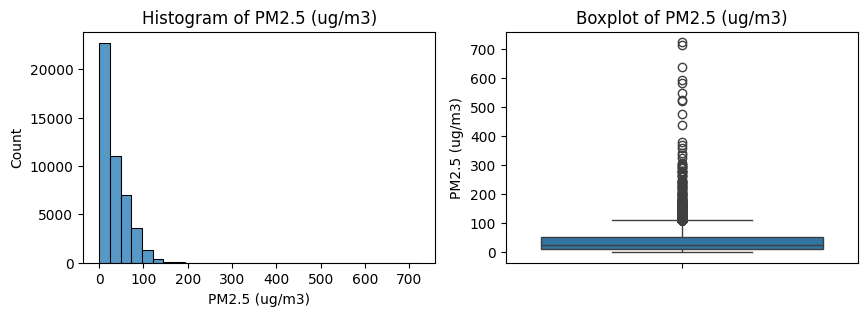

PM2.5 (ug/m3)- skewness: 2.6793738166313483
PM2.5 (ug/m3)- kurtosis: 27.93893719392045


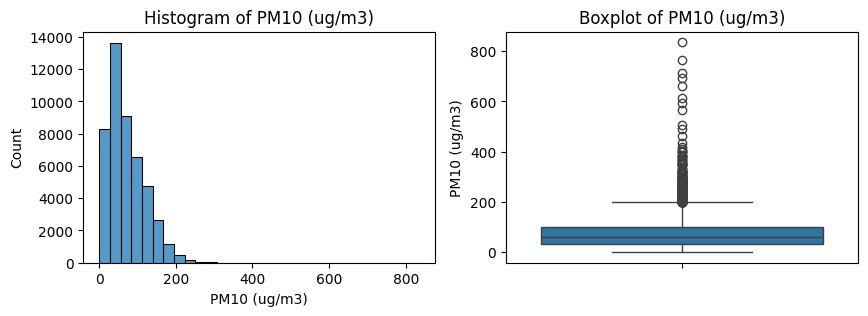

PM10 (ug/m3)- skewness: 1.4340834783193601
PM10 (ug/m3)- kurtosis: 6.465118620023276


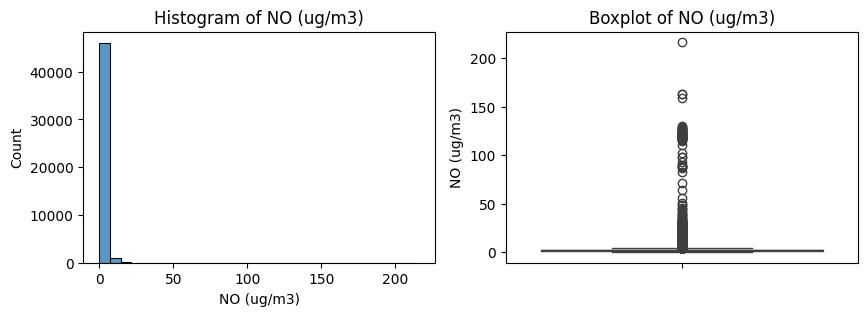

NO (ug/m3)- skewness: 21.029569837277414
NO (ug/m3)- kurtosis: 521.2975017937874


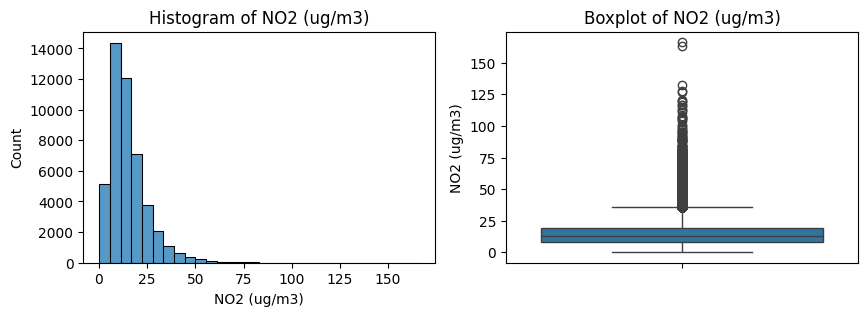

NO2 (ug/m3)- skewness: 2.2747654787963114
NO2 (ug/m3)- kurtosis: 10.673866464295585


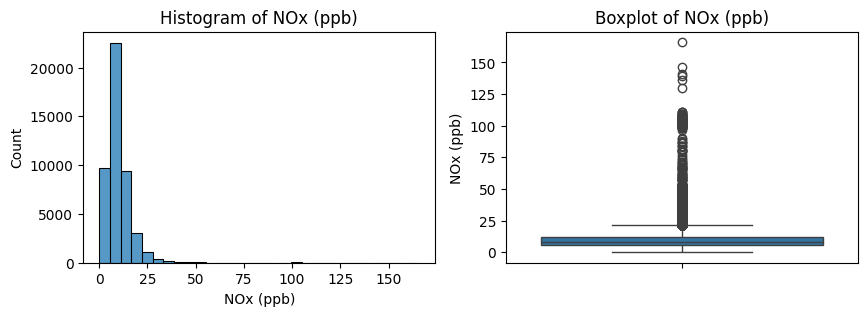

NOx (ppb)- skewness: 5.418381007037878
NOx (ppb)- kurtosis: 60.92075455791434


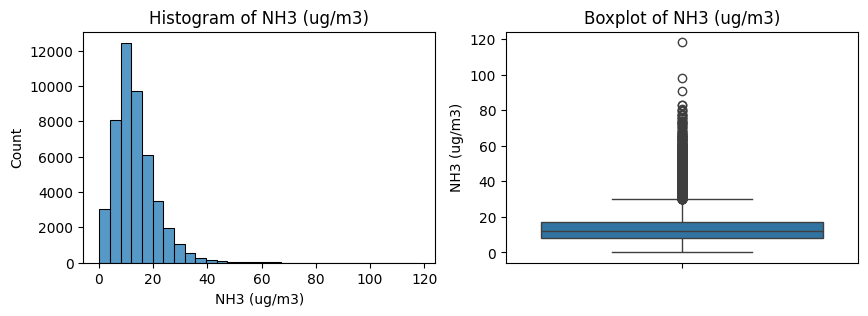

NH3 (ug/m3)- skewness: 1.7648936250710854
NH3 (ug/m3)- kurtosis: 7.148417329978384


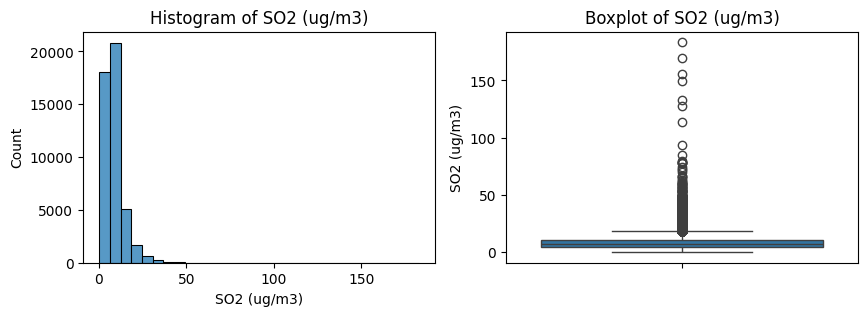

SO2 (ug/m3)- skewness: 4.233689700181873
SO2 (ug/m3)- kurtosis: 58.96204398921489


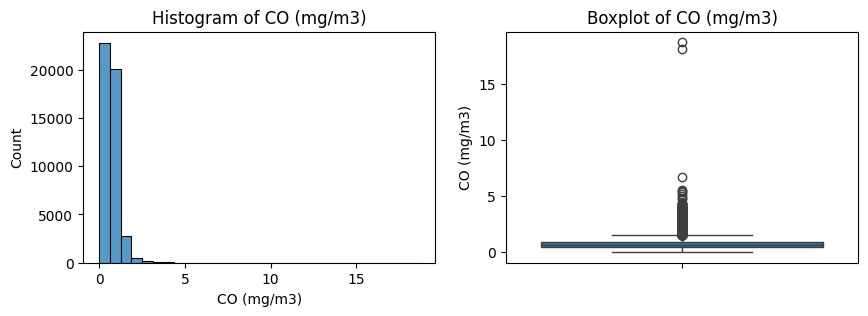

CO (mg/m3)- skewness: 4.802395142861718
CO (mg/m3)- kurtosis: 124.64404879134308


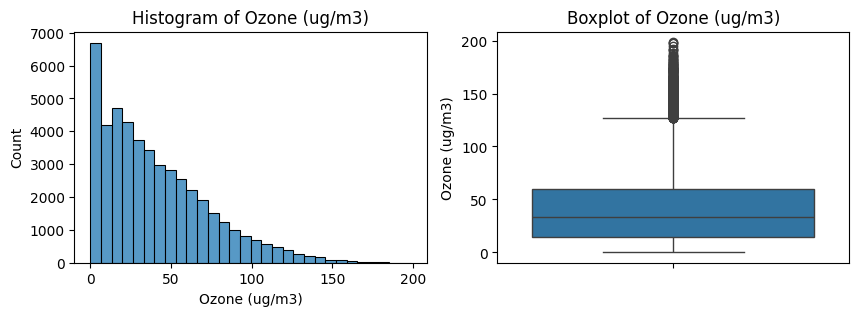

Ozone (ug/m3)- skewness: 1.0660100093874267
Ozone (ug/m3)- kurtosis: 0.8548360076736543


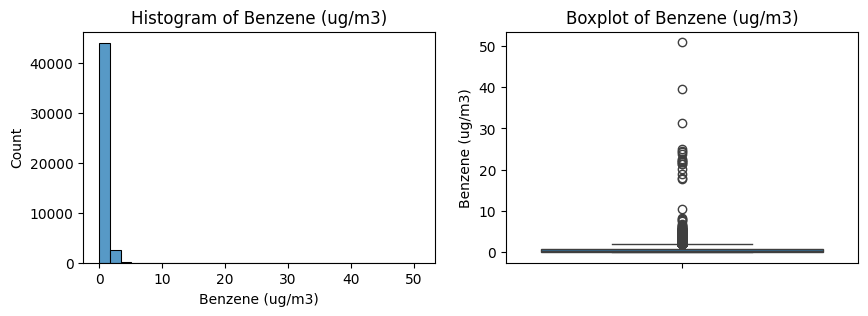

Benzene (ug/m3)- skewness: 16.061884826221167
Benzene (ug/m3)- kurtosis: 665.7025838131431


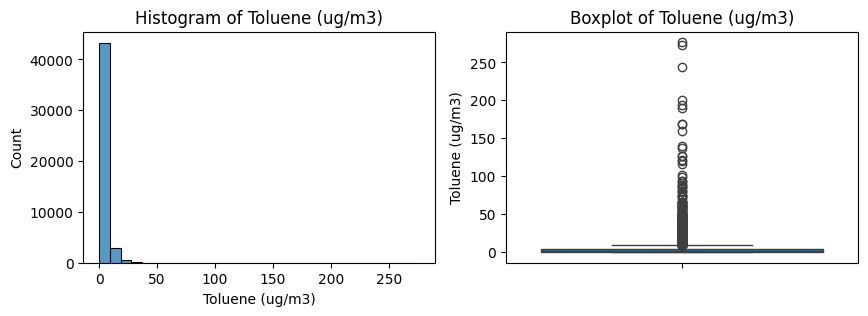

Toluene (ug/m3)- skewness: 14.523730259707175
Toluene (ug/m3)- kurtosis: 468.4836694375423


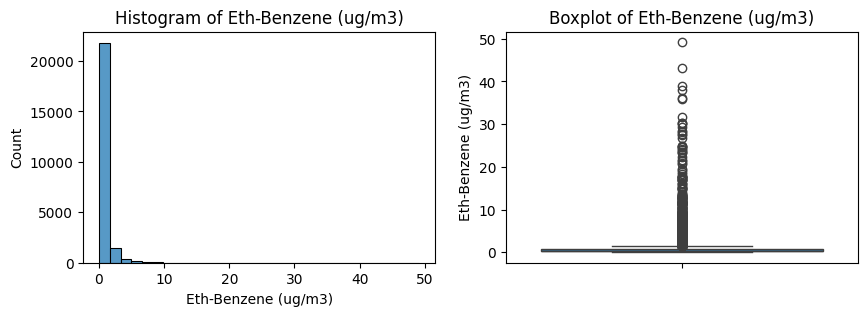

Eth-Benzene (ug/m3)- skewness: 11.053247592195891
Eth-Benzene (ug/m3)- kurtosis: 195.7636910130854


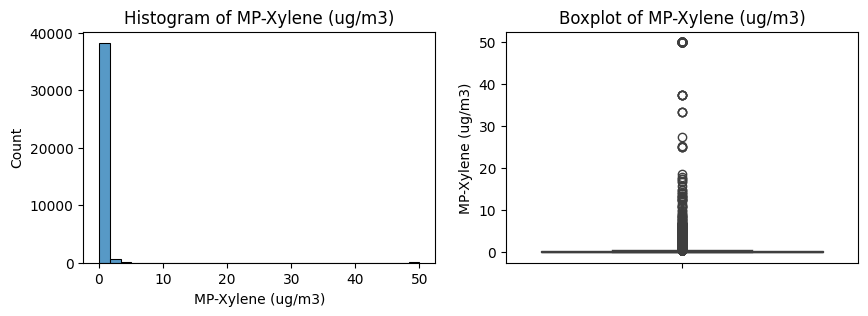

MP-Xylene (ug/m3)- skewness: 19.358976845098184
MP-Xylene (ug/m3)- kurtosis: 397.2977646669832


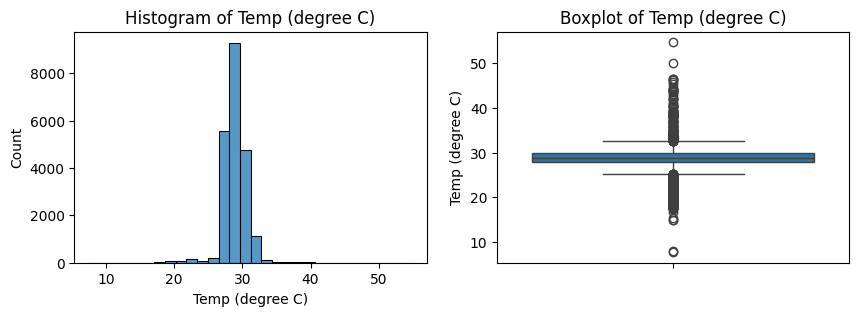

Temp (degree C)- skewness: -0.3116664252884092
Temp (degree C)- kurtosis: 16.053458730873157


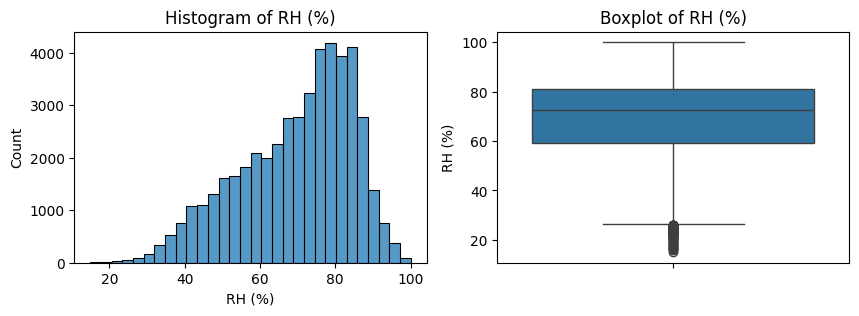

RH (%)- skewness: -0.6113444633948016
RH (%)- kurtosis: -0.3688411224840098


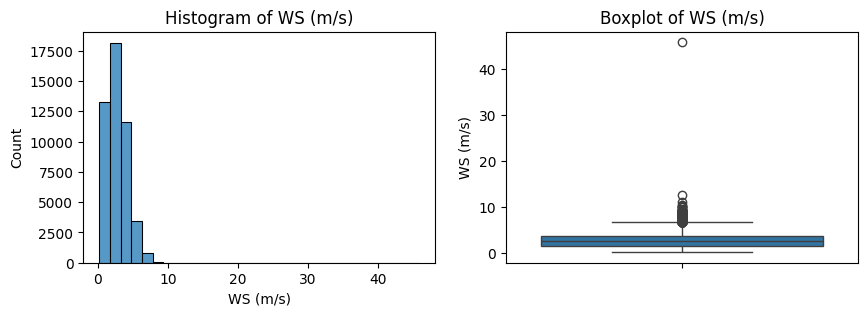

WS (m/s)- skewness: 1.309504056610714
WS (m/s)- kurtosis: 17.301754332941307


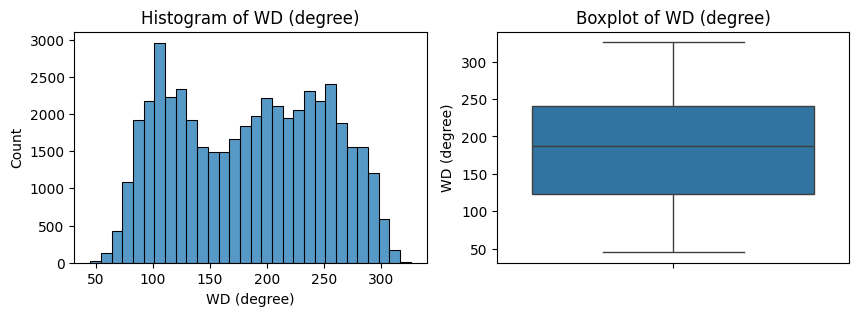

WD (degree)- skewness: 0.00458797989758055
WD (degree)- kurtosis: -1.2193853438601645


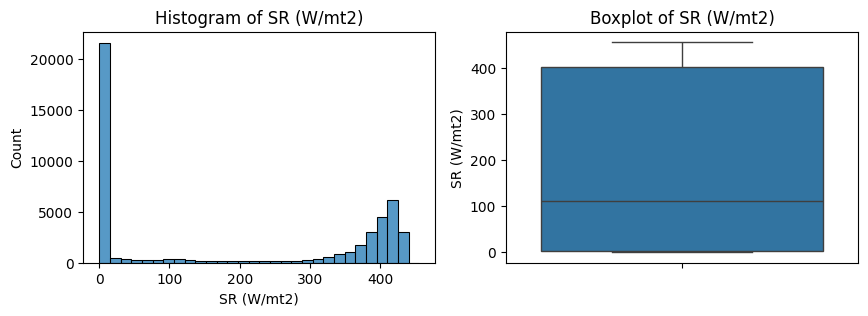

SR (W/mt2)- skewness: 0.11619422556208797
SR (W/mt2)- kurtosis: -1.8982926824201378


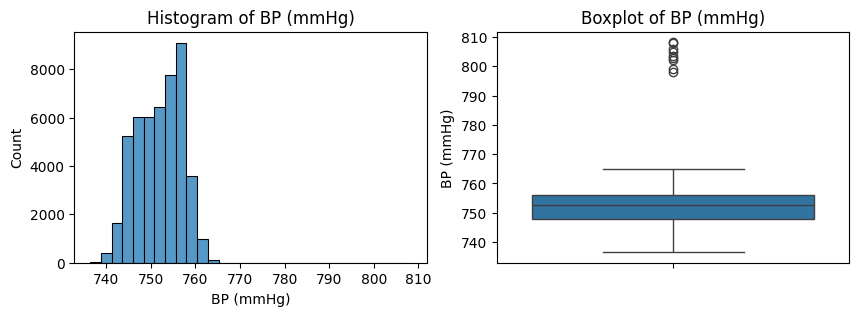

BP (mmHg)- skewness: 0.037980689855938325
BP (mmHg)- kurtosis: 1.15557270717696


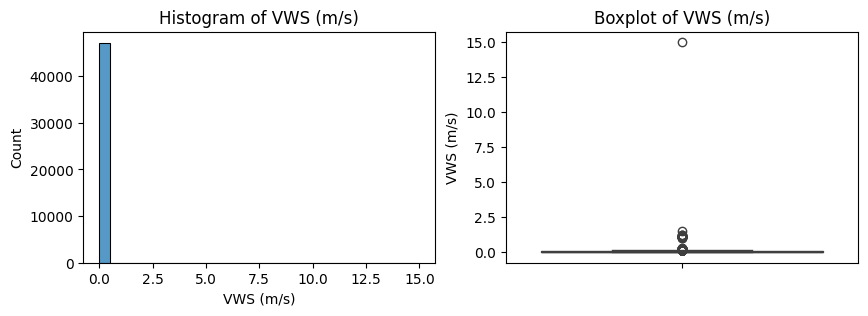

VWS (m/s)- skewness: 128.58459033354723
VWS (m/s)- kurtosis: 23216.09703235754


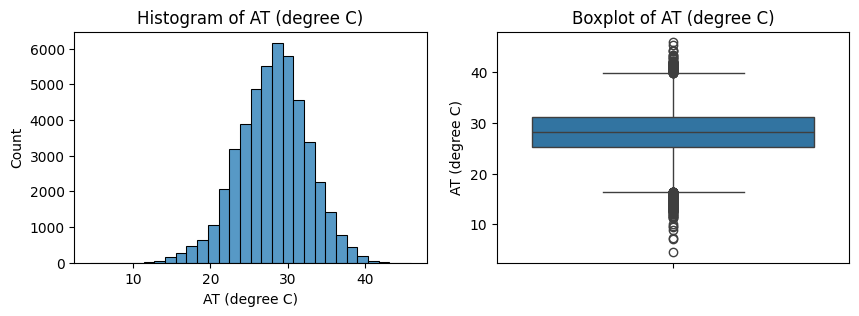

AT (degree C)- skewness: -0.16938815427451256
AT (degree C)- kurtosis: 0.17797051303488054


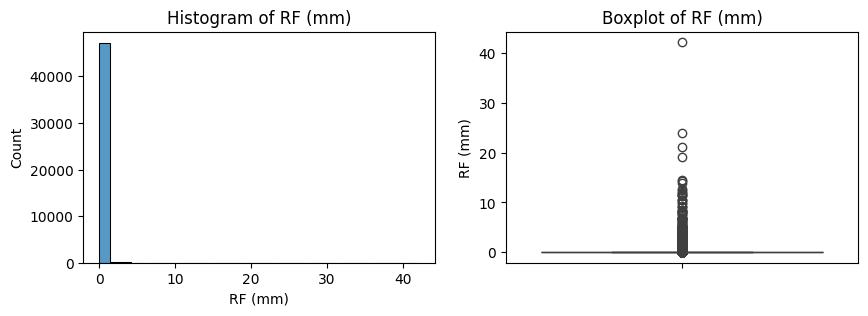

RF (mm)- skewness: 36.25278973226556
RF (mm)- kurtosis: 2297.1288660074856


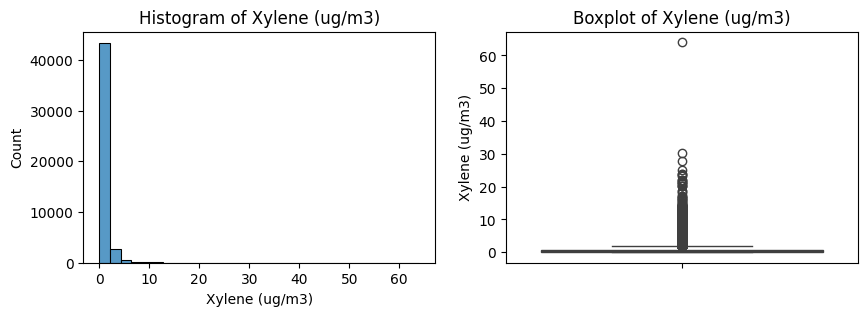

Xylene (ug/m3)- skewness: 7.892622657565698
Xylene (ug/m3)- kurtosis: 174.81031692679807


In [17]:
def dist_plot(df, numerical_cols):
  for i in numerical_cols:
    plt.figure(figsize=(10,3))

    plt.subplot(1,2,1)
    sns.histplot(df[i], bins=30)
    plt.title(f"Histogram of {i}")

    plt.subplot(1,2,2)
    sns.boxplot(df[i])
    plt.title(f"Boxplot of {i}")

    plt.show()

    print(f"{i}- skewness: {df[i].skew()}")
    print(f"{i}- kurtosis: {df[i].kurt()}")

dist_plot(data[numerical], numerical)

- Since most of the distributions are right skewed and contain many outliers, using the median for imputation is a more appropriate choice. Median is robust to extreme values and better represents the central tendency of skewed data, making it especially suitable when outliers are retained in the dataset.

- Most features exhibit differing scales and right skewed distributions. To bring all variables into a comparable range while preserving the original distribution shape, MinMax Scaler is the most suitable option. This method scales all values to a [0, 1] range.

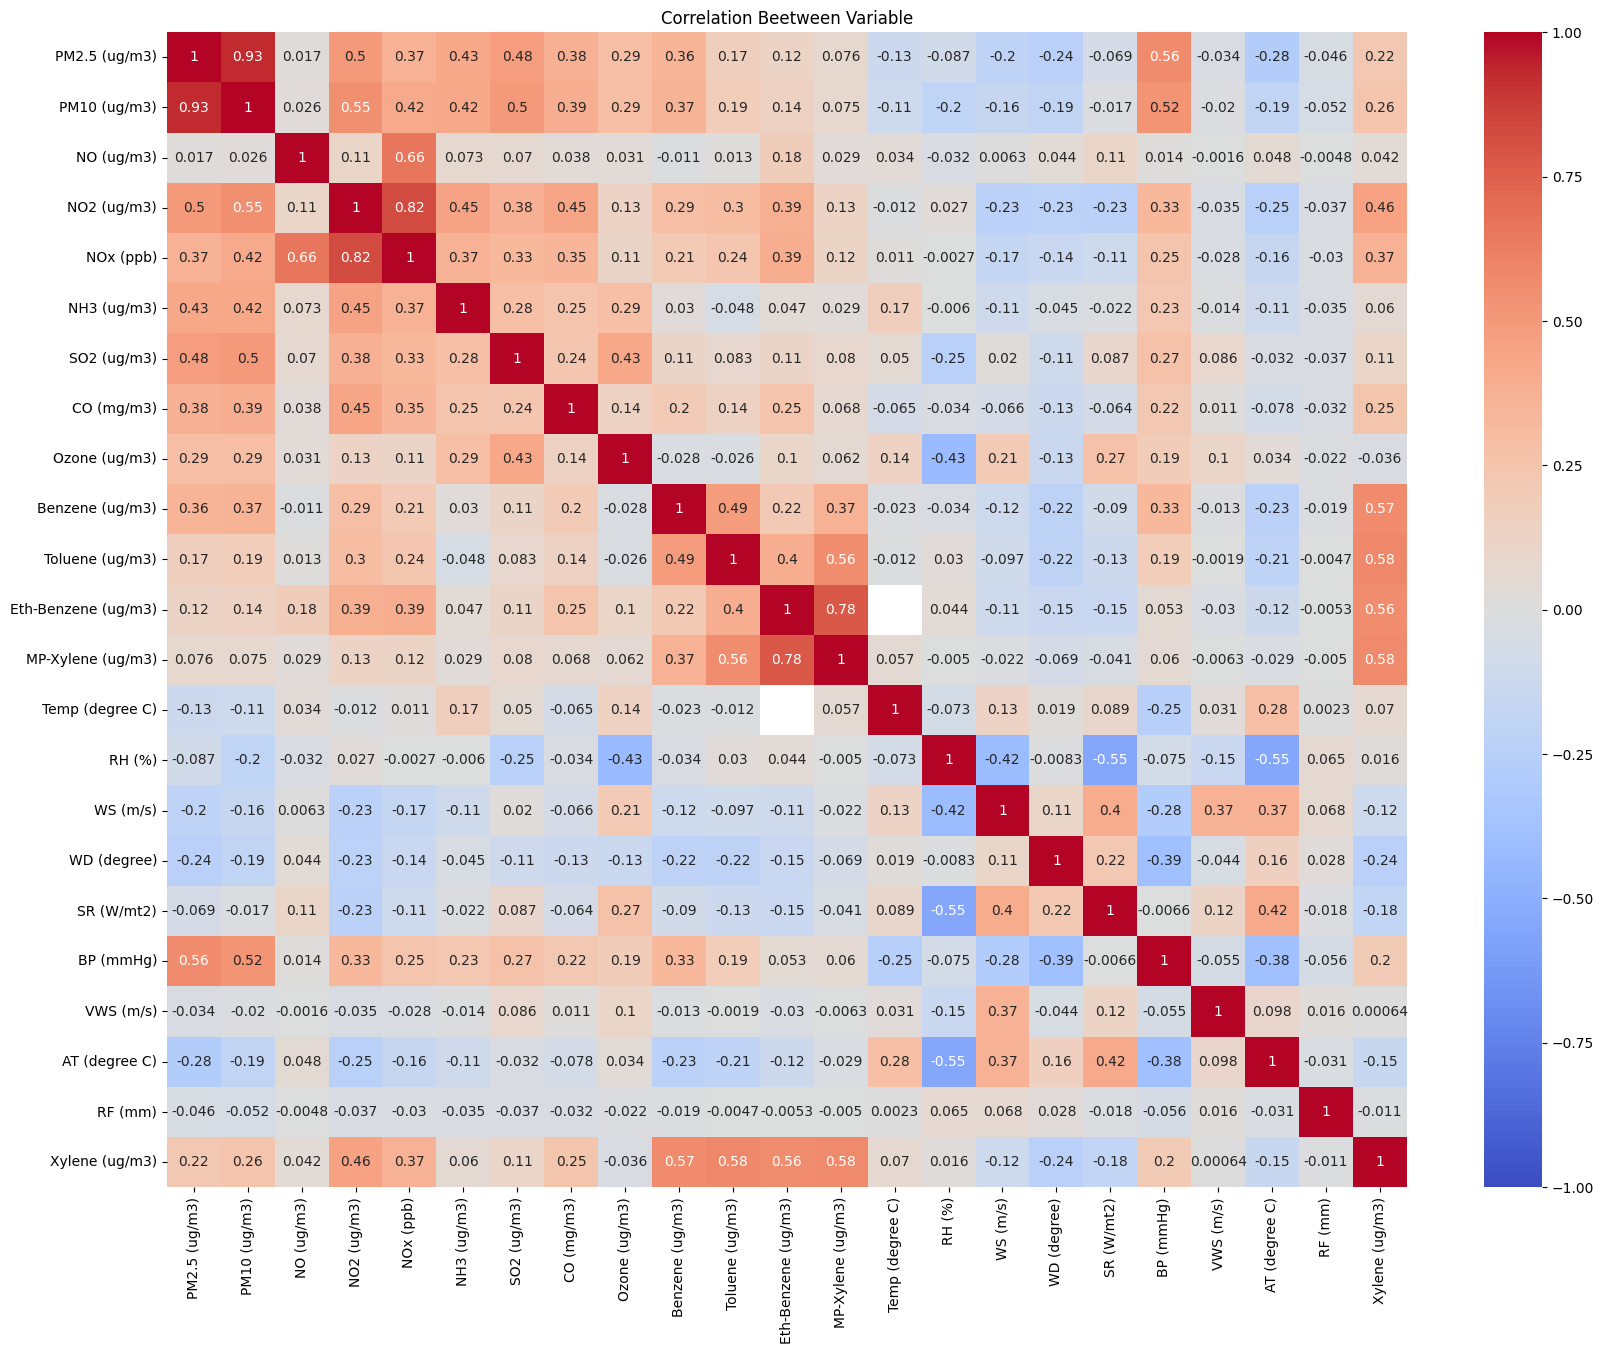

In [18]:
plt.figure(figsize=(20,15))
sns.heatmap(data[numerical].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Beetween Variable')
plt.show()

- Air Temperature (AT) shows a fairly strong negative correlation with Relative Humidity (RH) at -0.55. Logically, as air warms, its capacity to hold water vapor increases, so a higher temperature usually means lower relative humidity. This negative correlation reflects a common atmospheric dynamic.

- AT is also negatively correlated with Barometric Pressure (BP) at roughly -0.38. Hot conditions especially intense surface heating at midday in the dry season tend to weaken surface pressure. Warm air expands, becomes less dense, and lowers the measured pressure.

- The correlation between AT and Solar Radiation (SR) is positive, about 0.42. This is intuitive: solar radiation is a primary driver of atmospheric warming, so higher incoming solar energy typically raises air temperature.

- Most other pollutants such as NO, NO₂, NOx, CO, SO₂, and NH₃ have very weak correlations with AT. This suggests air temperature is not the dominant driver of their concentration variability, or that temperature effects only emerge under specific conditions (e.g., temperature inversions).

- There are strong inter pollutant correlations, notably between PM2.5 and PM10 (0.93) and between NO₂ and NOx (0.82). Such high coefficients make sense because these pollutant pairs often share common emission sources (e.g., vehicle exhaust or combustion), so increases in one are closely mirrored by increases in the other.

## Handling Missing Value

In [19]:
print(data.isnull().sum())

From Date                  0
To Date                    0
PM2.5 (ug/m3)           2458
PM10 (ug/m3)            1885
NO (ug/m3)              1558
NO2 (ug/m3)             1578
NOx (ppb)               2174
NH3 (ug/m3)             1662
SO2 (ug/m3)             2153
CO (mg/m3)              2415
Ozone (ug/m3)           1646
Benzene (ug/m3)         1888
Toluene (ug/m3)         1894
Eth-Benzene (ug/m3)    24814
MP-Xylene (ug/m3)       9546
Temp (degree C)        27203
RH (%)                  1438
WS (m/s)                1427
WD (degree)             1429
SR (W/mt2)              1656
BP (mmHg)               1429
VWS (m/s)               1626
AT (degree C)           1516
RF (mm)                 1292
Xylene (ug/m3)          1727
dtype: int64


- Although there are many null values, I will not drop the columns because each column plays an important role in predicting AT (degree C). Therefore, I will impute the missing values using the median.

In [20]:
for col in data.columns:
  if data[col].isnull().sum() > 0:
    data[col].fillna(data[col].median(), inplace= True)

C:\Users\Kelvin Jonathan\AppData\Local\Temp\ipykernel_29288\47350271.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace= True)
C:\Users\Kelvin Jonathan\AppData\Local\Temp\ipykernel_29288\47350271.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves 

In [21]:
print(data.isnull().sum())

From Date              0
To Date                0
PM2.5 (ug/m3)          0
PM10 (ug/m3)           0
NO (ug/m3)             0
NO2 (ug/m3)            0
NOx (ppb)              0
NH3 (ug/m3)            0
SO2 (ug/m3)            0
CO (mg/m3)             0
Ozone (ug/m3)          0
Benzene (ug/m3)        0
Toluene (ug/m3)        0
Eth-Benzene (ug/m3)    0
MP-Xylene (ug/m3)      0
Temp (degree C)        0
RH (%)                 0
WS (m/s)               0
WD (degree)            0
SR (W/mt2)             0
BP (mmHg)              0
VWS (m/s)              0
AT (degree C)          0
RF (mm)                0
Xylene (ug/m3)         0
dtype: int64


## Check Duplicated Value

In [22]:
print(data.duplicated().sum())

0


- Since there are no duplicated values, no handling is needed.

## Split

In [23]:
target= ['AT (degree C)']
features= [col for col in data.columns if col not in ['To Date', 'From Date', target]]
print(f"\nFeatures: {features}")
print(f"Target: {target}")


Features: ['PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Toluene (ug/m3)', 'Eth-Benzene (ug/m3)', 'MP-Xylene (ug/m3)', 'Temp (degree C)', 'RH (%)', 'WS (m/s)', 'WD (degree)', 'SR (W/mt2)', 'BP (mmHg)', 'VWS (m/s)', 'AT (degree C)', 'RF (mm)', 'Xylene (ug/m3)']
Target: ['AT (degree C)']


In [24]:
train_size= int(0.8 * len(data))
val_size= int(0.9 * len(data))

train_data= data.iloc[:train_size]
val_data= data.iloc[train_size:val_size]
test_data= data.iloc[val_size:]

In [25]:
print(f"\nData split: Train({len(train_data)}), Val({len(val_data)}), Test({len(test_data)})")


Data split: Train(39041), Val(4880), Test(4881)


## Scaling

In [26]:
scaler= MinMaxScaler()
scaler.fit(train_data[features])

train_scaled= scaler.transform(train_data[features])
val_scaled= scaler.transform(val_data[features])
test_scaled= scaler.transform(test_data[features])

- Use MinMax Scaler as previously explained

## Windowing 

In [27]:
def create_dataset(data, window_size= 5, target_cols=['AT (degree C)']):
  x, y= [], []
  for i in range(len(data) - window_size):
    x.append(data[i:(i + window_size), :])
    next_step= i + window_size
    y.append([data[next_step, features.index(col)] for col in target_cols])
  return np.array(x), np.array(y)

- Create a sliding window dataset using a custom function with a window size = 5. For each time step, a sequence of features is used as input (X), and the target value at the next time step is used as output (y).

In [28]:
window_size= 5  
x_train, y_train= create_dataset(train_scaled, window_size, target)
x_val, y_val= create_dataset(val_scaled, window_size, target)
x_test, y_test= create_dataset(test_scaled, window_size, target)

- Apply this function to the scaled training, validation, and test sets to generate the final datasets: `x_train`, `y_train`, `x_val`, `y_val`, `x_test`, and `y_test`.

In [29]:
print(f"\nWindow dataset shapes:")
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_val: {x_val.shape}, y_val: {y_val.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")


Window dataset shapes:
x_train: (39036, 5, 23), y_train: (39036, 1)
x_val: (4875, 5, 23), y_val: (4875, 1)
x_test: (4876, 5, 23), y_test: (4876, 1)


## Model LSTM Baseline

In [30]:
def build_baseline_lstm():
  model= Sequential([
    LSTM(10, input_shape= (x_train.shape[1], x_train.shape[2])),
    Dense(1, activation= 'linear'),
  ])
  model.compile(optimizer= Adam(learning_rate= 0.001), loss= 'mse', metrics= ['mae'])
  return model

In [31]:
baseline_model= build_baseline_lstm()
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                1360      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 1,371
Trainable params: 1,371
Non-trainable params: 0
_________________________________________________________________


### Training Model LSTM Baseline

In [32]:
history= baseline_model.fit(
  x_train, y_train,
  validation_data= (x_val, y_val),
  epochs= 20,
  batch_size= 32,
  verbose= 1
)

Epoch 1/20
1220/1220 [==============================] - 36s 19ms/step - loss: 0.0062 - mae: 0.0487 - val_loss: 0.0019 - val_mae: 0.0349
Epoch 2/20
1220/1220 [==============================] - 22s 18ms/step - loss: 0.0012 - mae: 0.0240 - val_loss: 9.1056e-04 - val_mae: 0.0234
Epoch 3/20
1220/1220 [==============================] - 21s 17ms/step - loss: 9.2922e-04 - mae: 0.0205 - val_loss: 6.8865e-04 - val_mae: 0.0203
Epoch 4/20
1220/1220 [==============================] - 22s 18ms/step - loss: 7.9852e-04 - mae: 0.0186 - val_loss: 5.5696e-04 - val_mae: 0.0181
Epoch 5/20
1220/1220 [==============================] - 21s 17ms/step - loss: 7.2888e-04 - mae: 0.0174 - val_loss: 5.4855e-04 - val_mae: 0.0180
Epoch 6/20
1220/1220 [==============================] - 19s 16ms/step - loss: 6.8693e-04 - mae: 0.0167 - val_loss: 4.4541e-04 - val_mae: 0.0159
Epoch 7/20
1220/1220 [==============================] - 20s 16ms/step - loss: 6.5287e-04 - mae: 0.0161 - val_loss: 6.0645e-04 - val_mae: 0.0195
Epoc

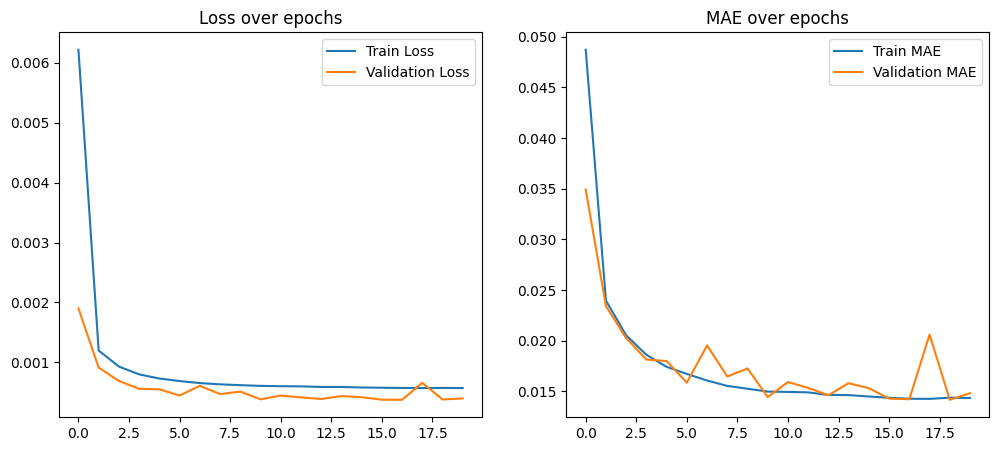

In [33]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE over epochs')
plt.legend()
plt.show()

- The training and validation loss curves both show a sharp decrease within the first few epochs and then stabilize at low values, indicating that the model is learning effectively without overfitting.

- Similarly, the MAE (Mean Absolute Error) curves for both training and validation sets converge to low values, with minimal gap between them, suggesting good generalization performance on unseen data.

### Forecast Model LSTM Baseline

In [34]:
forecast= pd.read_csv('AP004.csv') 
forecast['From Date']= pd.to_datetime(data['From Date'])
forecast.set_index('From Date', inplace=True)

In [35]:
predicted_values= baseline_model.predict(x_test)

153/153 [==============================] - 1s 6ms/step


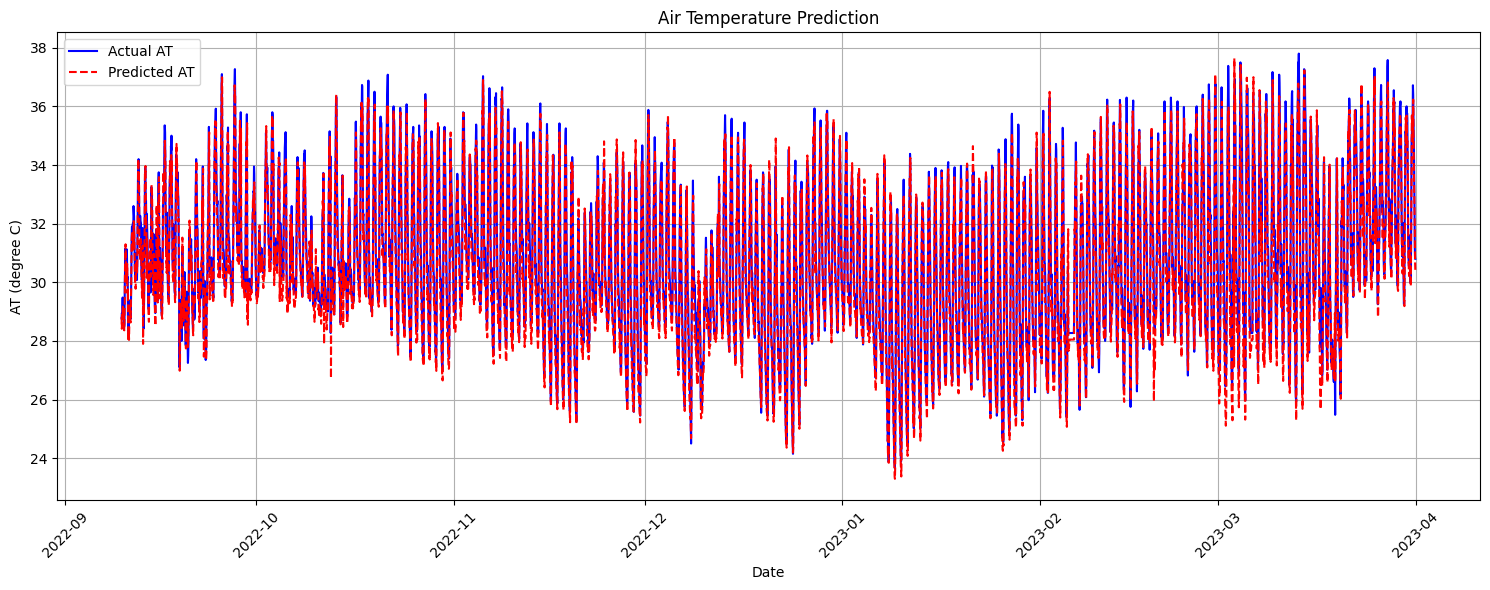

In [36]:
AT_scaler= MinMaxScaler().fit(data[['AT (degree C)']])

actual_AT= AT_scaler.inverse_transform(y_test[:, 0].reshape(-1, 1))

predicted_AT= AT_scaler.inverse_transform(predicted_values[:, 0].reshape(-1, 1))

results= pd.DataFrame({
    'From Date': test_data['From Date'].iloc[window_size:window_size+len(y_test)].values,
    'Actual_AT': actual_AT.flatten(),
    'Predicted_AT': predicted_AT.flatten(),
})

plt.figure(figsize=(15, 6))
plt.plot(results['From Date'], results['Actual_AT'], 'b-', label='Actual AT')
plt.plot(results['From Date'], results['Predicted_AT'], 'r--', label='Predicted AT')
plt.title('Air Temperature Prediction')
plt.xlabel('Date')
plt.ylabel('AT (degree C)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- The line plot shows that the predicted air temperature (red dashed line) closely follows the actual air temperature (blue line) over time, indicating that the model captures the temporal patterns effectively.

- Despite some fluctuations, the overall alignment between the predicted and actual values demonstrates that the model performs well on the test set.

### Evaluation Model LSTM Baseline

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred= np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model(actual, predicted):
  return {
    'MSE': mean_squared_error(actual, predicted),
    'MAE': mean_absolute_error(actual, predicted),
    'MAPE': mean_absolute_percentage_error(actual, predicted),
    'R2': r2_score(actual, predicted)
  }

AT_metrics= evaluate_model(results['Actual_AT'], results['Predicted_AT'])

print("\nEvaluation Metrics for AT:")
print(f"MSE: {AT_metrics['MSE']:.6f}")
print(f"MAE: {AT_metrics['MAE']:.6f}")
print(f"MAPE: {AT_metrics['MAPE']:.4f}%")
print(f"R2: {AT_metrics['R2']:.4f}")

metrics_df = pd.DataFrame({
  'Target': ['AT (degree C)'],
  'MSE': [AT_metrics['MSE']],
  'MAE': [AT_metrics['MAE']],
  'MAPE': [AT_metrics['MAPE']],
  'R2': [AT_metrics['R2']]
})

print("\nSummary of Evaluation Metrics in Model Baseline:")
print(metrics_df)


Evaluation Metrics for AT:
MSE: 0.463263
MAE: 0.500021
MAPE: 1.6194%
R2: 0.9345

Summary of Evaluation Metrics:
          Target       MSE       MAE      MAPE        R2
0  AT (degree C)  0.463263  0.500021  1.619426  0.934537


- The model achieved strong performance in predicting air temperature (AT), with a low Mean Squared Error (MSE) of 0.463 and a Mean Absolute Error (MAE) of 0.500, indicating minimal average deviation from actual values.

- A very low Mean Absolute Percentage Error (MAPE) of 1.62% and a high R² score of 0.9345 confirm that the model explains approximately 93% of the variance in the target variable, showing excellent predictive accuracy.

## Modified LSTM Model

In [38]:
def build_model(hp):
  model= Sequential()
    
  for i in range(hp.Int('num_layers', 1, 1)): 
    units= hp.Int(f'units_layer_{i}', min_value= 192, max_value= 256, step= 64)
    dropout_rate= hp.Float(f'dropout_layer_{i}', min_value= 0.2, max_value= 0.4, step= 0.1)

    if i == 0:
      model.add(LSTM(units,
        input_shape= (x_train.shape[1], x_train.shape[2]),
        return_sequences= (i < hp.get('num_layers') - 1)))
    else:
      model.add(LSTM(units,
        return_sequences= (i < hp.get('num_layers') - 1)))
        
    model.add(Dropout(dropout_rate))
    
  model.add(Dense(
    units= hp.Int('dense_units', min_value= 64, max_value= 128, step= 64),
    activation='relu'
  ))
    
  model.add(Dense(2, activation= 'linear'))

  lr= hp.Choice('learning_rate', values=[1e-2, 1e-3])
    
  model.compile(
    optimizer= Adam(learning_rate= lr),
    loss= 'mse',
    metrics= ['mae']
  )
    
  return model

- This function defines a model architecture with hyperparameters that can be tuned, such as the number of LSTM units, dropout rates, dense layer size, and learning rate.

- Similar to Grid Search, this setup allows the model to search for the best combination of hyperparameter values using a tuning framework like Keras Tuner to achieve optimal performance.

In [39]:
tuner= kt.GridSearch(
  build_model,
  objective= 'val_loss',
  executions_per_trial= 1, 
  directory= 'lstm_tuning',
  project_name= 'Air_Temperature_forecast'
)

In [40]:
tuner.search(
  x_train, y_train,
  epochs= 20,
  batch_size= 32,
  validation_data= (x_val, y_val),
  callbacks= [EarlyStopping(patience=5)],
  verbose= 1
)

Trial 24 Complete [00h 03m 30s]
val_loss: 0.00035859039053320885

Best val_loss So Far: 0.000357501587131992
Total elapsed time: 01h 12m 00s


In [41]:
best_model= tuner.get_best_models(num_models= 1)[0]

In [42]:
print("\nHasil Grid Search:")
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Hyperparameters:
- Jumlah Layer: {best_hps.get('num_layers')}
- Unit per Layer: {[best_hps.get(f'units_layer_{i}') for i in range(best_hps.get('num_layers'))]}
- Dropout Rates: {[best_hps.get(f'dropout_layer_{i}') for i in range(best_hps.get('num_layers'))]}
- Dense Units: {best_hps.get('dense_units')}
- Learning Rate: {best_hps.get('learning_rate')}
""")


Hasil Grid Search:

Best Hyperparameters:
- Jumlah Layer: 1
- Unit per Layer: [256]
- Dropout Rates: [0.2]
- Dense Units: 128
- Learning Rate: 0.001



### Training Modified LSTM Model

In [43]:
history= best_model.fit(
  x_train, y_train,
  validation_data= (x_val, y_val),
  epochs= 100,
  batch_size= 32,
  callbacks= [EarlyStopping(patience=10, restore_best_weights=True)],
  verbose= 1
)

Epoch 1/100
1220/1220 [==============================] - 15s 11ms/step - loss: 5.7718e-04 - mae: 0.0152 - val_loss: 4.6026e-04 - val_mae: 0.0166
Epoch 2/100
1220/1220 [==============================] - 12s 10ms/step - loss: 5.8421e-04 - mae: 0.0155 - val_loss: 3.5041e-04 - val_mae: 0.0136
Epoch 3/100
1220/1220 [==============================] - 12s 10ms/step - loss: 5.7958e-04 - mae: 0.0152 - val_loss: 3.6308e-04 - val_mae: 0.0139
Epoch 4/100
1220/1220 [==============================] - 13s 10ms/step - loss: 5.5074e-04 - mae: 0.0147 - val_loss: 3.4944e-04 - val_mae: 0.0139
Epoch 5/100
1220/1220 [==============================] - 13s 10ms/step - loss: 5.5268e-04 - mae: 0.0149 - val_loss: 3.7339e-04 - val_mae: 0.0140
Epoch 6/100
1220/1220 [==============================] - 13s 11ms/step - loss: 5.5237e-04 - mae: 0.0149 - val_loss: 4.2731e-04 - val_mae: 0.0154
Epoch 7/100
1220/1220 [==============================] - 13s 10ms/step - loss: 5.5874e-04 - mae: 0.0148 - val_loss: 4.1461e-04 - v

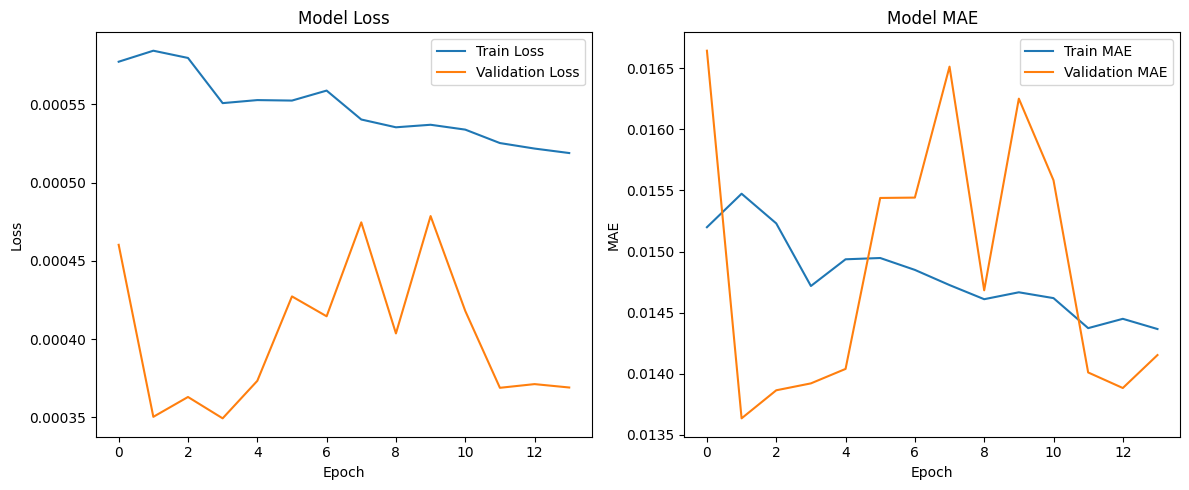

In [44]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

- Although the validation loss and MAE plots appear visually unstable due to small fluctuations, the overall values stay within a narrow range. This indicates that the model's performance is actually stable throughout the epochs.

- Compared to the previous training plot, the range of variation in this plot is much smaller. The scale of the y-axis exaggerates the visual differences, but numerically the validation metrics are consistent and indicate stable generalization.

### Forecast Modified LSTM Model

In [45]:
predicted_values= best_model.predict(x_test)

153/153 [==============================] - 1s 4ms/step


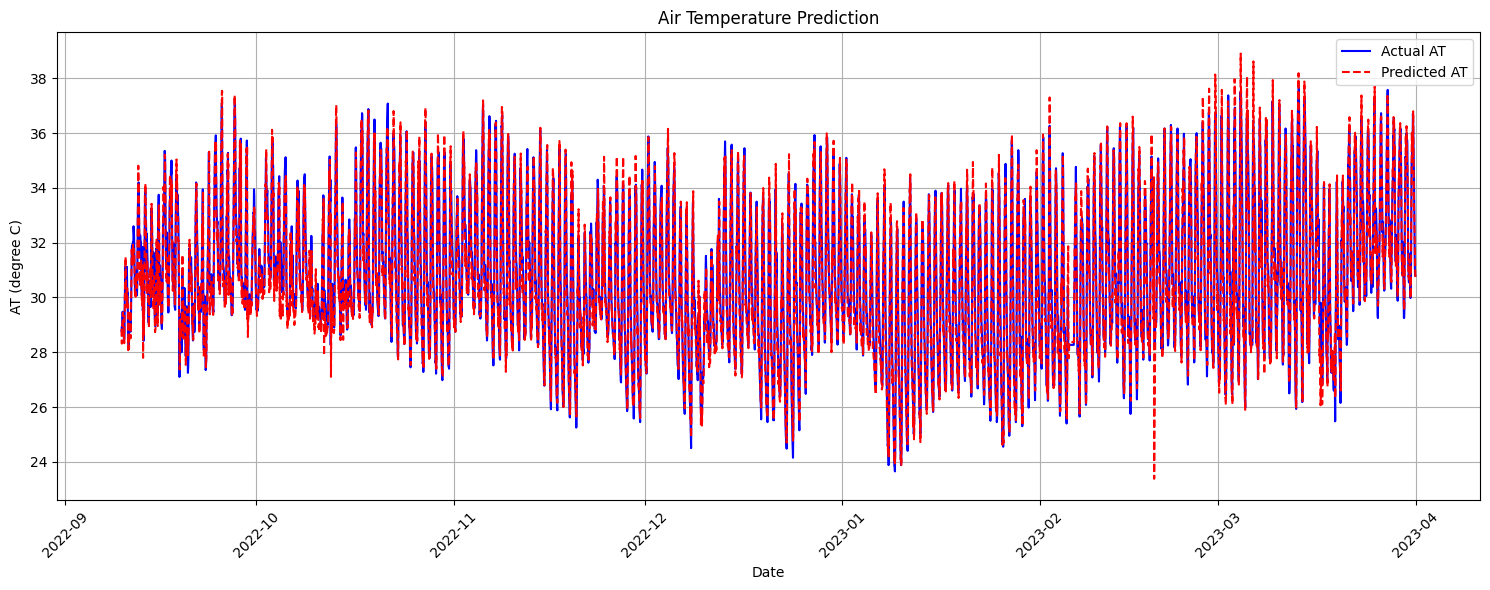

In [46]:
AT_scaler= MinMaxScaler().fit(data[['AT (degree C)']])

actual_AT= AT_scaler.inverse_transform(y_test[:, 0].reshape(-1, 1))

predicted_AT= AT_scaler.inverse_transform(predicted_values[:, 0].reshape(-1, 1))

results= pd.DataFrame({
    'From Date': test_data['From Date'].iloc[window_size:window_size+len(y_test)].values,
    'Actual_AT': actual_AT.flatten(),
    'Predicted_AT': predicted_AT.flatten(),
})

plt.figure(figsize=(15, 6))
plt.plot(results['From Date'], results['Actual_AT'], 'b-', label='Actual AT')
plt.plot(results['From Date'], results['Predicted_AT'], 'r--', label='Predicted AT')
plt.title('Air Temperature Prediction')
plt.xlabel('Date')
plt.ylabel('AT (degree C)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Compared to the previous prediction plot, this result shows a better fit between the predicted and actual air temperature values. The red dashed line (Predicted AT) closely follows the blue line (Actual AT) with minimal deviation.

- The model captures both the overall trend and the short term fluctuations more accurately, indicating improved prediction quality and better generalization to the test data.


In [47]:
def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred= np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model(actual, predicted):
  return {
    'MSE': mean_squared_error(actual, predicted),
    'MAE': mean_absolute_error(actual, predicted),
    'MAPE': mean_absolute_percentage_error(actual, predicted),
    'R2': r2_score(actual, predicted)
  }

AT_metrics= evaluate_model(results['Actual_AT'], results['Predicted_AT'])

print("\nEvaluation Metrics for AT:")
print(f"MSE: {AT_metrics['MSE']:.6f}")
print(f"MAE: {AT_metrics['MAE']:.6f}")
print(f"MAPE: {AT_metrics['MAPE']:.4f}%")
print(f"R2: {AT_metrics['R2']:.4f}")

metrics_df2 = pd.DataFrame({
  'Target': ['AT (degree C)'],
  'MSE': [AT_metrics['MSE']],
  'MAE': [AT_metrics['MAE']],
  'MAPE': [AT_metrics['MAPE']],
  'R2': [AT_metrics['R2']]
})

print("\nSummary of Evaluation Metrics in Modified Model:")
print(metrics_df2)


Evaluation Metrics for AT:
MSE: 0.417594
MAE: 0.462971
MAPE: 1.4914%
R2: 0.9410

Summary of Evaluation Metrics in Modified Model:
          Target       MSE       MAE      MAPE        R2
0  AT (degree C)  0.417594  0.462971  1.491425  0.940991


## Final Summary Evaluation

In [48]:
print("\nSummary of Evaluation Metrics in Baseline Model:")
print(metrics_df)
print("\nSummary of Evaluation Metrics in Modified Model:")
print(metrics_df2)


Summary of Evaluation Metrics in Baseline Model:
          Target       MSE       MAE      MAPE        R2
0  AT (degree C)  0.463263  0.500021  1.619426  0.934537

Summary of Evaluation Metrics in Modified Model:
          Target       MSE       MAE      MAPE        R2
0  AT (degree C)  0.417594  0.462971  1.491425  0.940991


- Compared to the baseline model, the modified model shows consistent improvement across all evaluation metrics:
  - **MSE** decreased from **0.4633** to **0.4176**
  - **MAE** decreased from **0.5000** to **0.4630**
  - **MAPE** decreased from **1.62%** to **1.49%**
  - **R² score** increased from **0.9345** to **0.9410**

- These improvements indicate that the modified model has better accuracy and generalization, making it more reliable for air temperature prediction.

# Bonus Question

### Is this problem suitable for a multivariate time series approach? How do you determine whether a problem can be approached as multivariate? 

This air temperature forecasting problem is inherently multivariate, as atmospheric and pollution variables are highly interdependent over time. Features like solar radiation (SR), wind speed/ direction (WS/WD), humidity (RH), and pollutants (e.g., PM2.5, NOx) all dynamically influence air temperature (AT). These interactions are both temporal and causal for instance, increased SR leads to higher AT and lower RH, while changes in wind direction can alter pollutant dispersion and heat retention. Such physical dependencies make univariate models insufficient.

The dataset contains timestamped measurements of 20+ variables, and exploratory data analysis revealed strong correlations (e.g., AT-RH: -0.55, AT-SR: 0.42). These cross feature relationships validate the use of multivariate models like LSTM, which can capture non linear, time lagged interactions more effectively. Empirically, multivariate approaches outperform univariate ones in short term prediction, making this framework not only appropriate but essential for accurate and realistic forecasting.